In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, stats
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
#pd.options.display.float_format = '{:.2f}'.format


## Čistenie

In [2]:
df = pd.read_csv("macro-economic-db-quarterly.csv", delimiter=";", index_col=0)
df = df.transpose()

df.reset_index(inplace=True)
df.rename(columns={"index":"stvrtrok"}, inplace=True)
for column in df.columns[1:]:
    df[column] = df[column].str.replace(",", "").astype(float)

columns_to_modify = df.columns.difference(["urok"])
df[columns_to_modify] = df[columns_to_modify].replace(0, np.nan)

df["bilancia"] = df.vyvoz - df.dovoz

df["NaN_Percentage"] = df.isna().sum(axis=1) / df.shape[1] * 100
df_cut =  df[df["NaN_Percentage"] <= 30].drop(columns=["NaN_Percentage"])
df_cut.reset_index(drop=True, inplace=True)

df_clean = df_cut.bfill()
df_clean = df_clean.ffill()

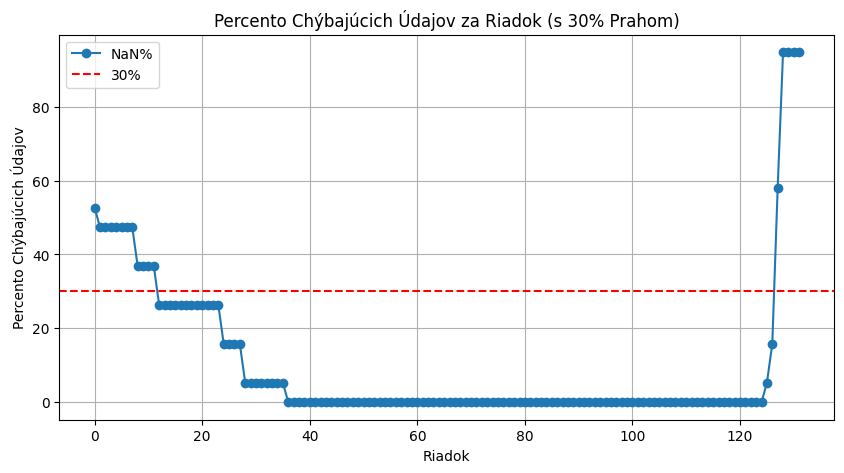

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["NaN_Percentage"], marker='o', linestyle='-', label="NaN%")


plt.axhline(y=30, color='r', linestyle='--', label="30%")


plt.xlabel("Riadok")
plt.ylabel("Percento Chýbajúcich Údajov")
plt.title("Percento Chýbajúcich Údajov za Riadok (s 30% Prahom)")
plt.legend()
plt.grid(True)


plt.show()


# Modelovanie

## HDP

In [3]:
#Rozdelenie a štandardizácia dát
X = df_clean[[ "m2", "nezamestnanost", "urok", "olej", "bilancia", "tvorba_kapitalu"]]
y = df_clean.hdp
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [4]:

# Generate synthetic dataset


# Define models
models = {
    "Lineárna Regresia": LinearRegression(),
    "Ridge": Ridge(alpha=0.1),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.9)
}

# DataFrame to store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    residuals = y_train - y_pred
    
    # Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = shapiro(residuals)
    
    # Breusch-Pagan test for heteroscedasticity
    X_with_const = sm.add_constant(X_train)  # Add constant term
    _, bp_pvalue, _, _ = het_breuschpagan(residuals, X_with_const)
    
    # Durbin-Watson test for autocorrelation
    dw_stat = durbin_watson(residuals)
    
    # Store results
    results.append({
        "Model": name,
        "SW p-hodnota": shapiro_p,
        "BP p-hodnota": bp_pvalue,
        "DW štatistika": dw_stat
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df


,Model,SW p-hodnota,BP p-hodnota,DW štatistika
0,Lineárna Regresia,0.123540,0.096222,2.036598
1,Ridge,0.125860,0.094577,2.034375
2,Lasso,0.123303,0.096031,2.036727
3,Elastic Net,0.125574,0.073491,2.019502


[[21734.94 22049.83]
 [12315.65 11131.18]
 [16476.19 15681.84]
 [20375.33 20015.23]
 [12223.92 11479.14]
 [17442.44 17611.31]
 [20616.66 20108.19]
 [20252.99 19962.61]
 [18255.43 19167.75]
 [12231.71 12348.91]
 [24695.   24631.41]
 [15210.61 14500.58]
 [22009.12 22424.69]
 [25405.64 25849.2 ]
 [12363.56 11831.87]
 [12099.14 10471.43]
 [20735.04 20348.51]
 [12777.01 12821.17]
 [25648.84 24997.56]
 [19202.31 17741.15]
 [23755.61 24223.76]
 [25367.12 25785.83]
 [12077.94 11916.08]]
R²: 0.9819100029461122


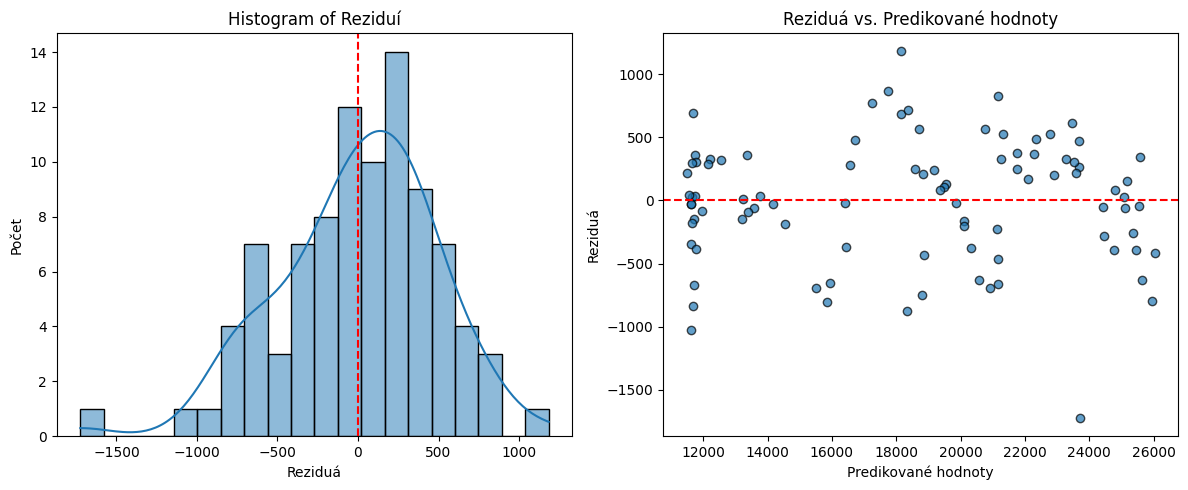

Shapiro-Wilk Test: Stat=0.9781, p=0.1235
Reziduá sú približne normálne.

Breusch-Pagan Test:
Test Statistic: 10.7559
p-value: 0.0962
Reziduá nevykazujú signifkantnú heteroskedasticitu.


In [5]:
#Lineárna regresia
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_test = mlr.predict(X_test)
y_pred_train = mlr.predict(X_train)

np.set_printoptions(precision=2)
print(np.concatenate((np.array(y_pred_test).reshape(len(y_pred_test), 1), np.array(y_test).reshape(len(y_test), 1)), 1))

r2_test = mlr.score(X_test, y_test)
print(f"R²: {r2_test}")


residuals = y_train - y_pred_train


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(residuals, bins=20, kde=True, ax=axs[0])
axs[0].axvline(0, color='red', linestyle='dashed') 
axs[0].set_title("Histogram of Reziduí")
axs[0].set_xlabel("Reziduá")
axs[0].set_ylabel("Počet")


axs[1].scatter(y_pred_train, residuals, alpha=0.7, edgecolor='k')
axs[1].axhline(y=0, color='red', linestyle='dashed')
axs[1].set_title("Reziduá vs. Predikované hodnoty")
axs[1].set_xlabel("Predikované hodnoty")
axs[1].set_ylabel("Reziduá")

plt.tight_layout()
plt.show()


stat, p = shapiro(residuals)
print(f"Shapiro-Wilk Test: Stat={stat:.4f}, p={p:.4f}")
if p > 0.05:
    print("Reziduá sú približne normálne.")
else:
    print("Reziduá sa signifikantne odchyľujú od normnality.")


X_test_with_const = sm.add_constant(X_train)
bp_test_stat, bp_test_pval, _, _ = het_breuschpagan(residuals, X_test_with_const)


print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat:.4f}")
print(f"p-value: {bp_test_pval:.4f}")


if bp_test_pval < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


In [6]:
#OLS

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_train_const = sm.add_constant(X_train)


ols_model = sm.OLS(y_train, X_train_const).fit()


print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                    hdp   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1435.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):           3.66e-83
Time:                        20:23:00   Log-Likelihood:                -699.09
No. Observations:                  92   AIC:                             1412.
Df Residuals:                      85   BIC:                             1430.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             1.84e+04     52.381    3

Ridge Regresia R² (Train): 0.9902
Ridge Regresia R² (Test): 0.9818

Breusch-Pagan Test:
Test Statistic: 10.80548373746621, p-value: 0.09457746710034852
Reziduá nevykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test:
Test Statistic: 0.9782, p-value: 0.1259
Reziduá sú približne normálne.


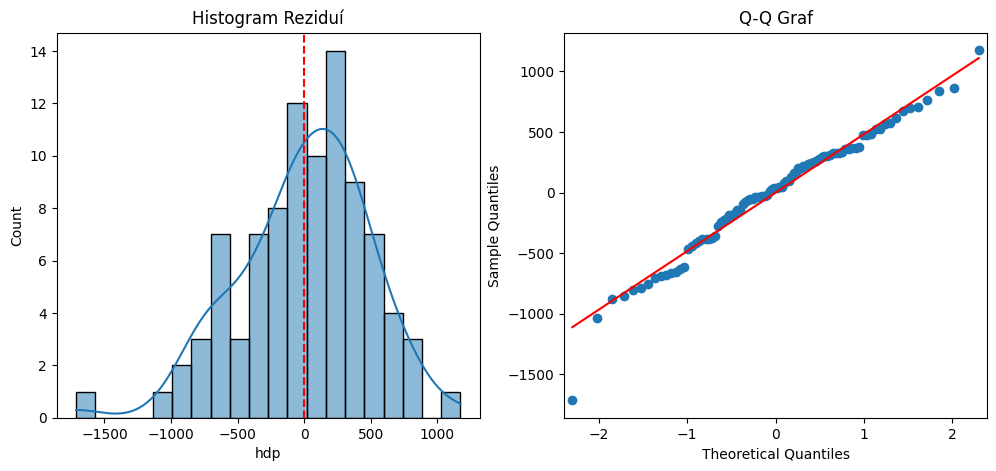

In [7]:
#Ridge
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)


y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)


ridge_r2_train = ridge_model.score(X_train, y_train)
ridge_r2_test = ridge_model.score(X_test, y_test)

print(f"Ridge Regresia R² (Train): {ridge_r2_train:.4f}")
print(f"Ridge Regresia R² (Test): {ridge_r2_test:.4f}")


ridge_residuals = y_train - y_train_pred




X_with_const = sm.add_constant(X_train)
ridge_bp_test = het_breuschpagan(ridge_residuals, X_with_const)
print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {ridge_bp_test[0]}, p-value: {ridge_bp_test[1]}")
if ridge_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(ridge_residuals)
print("\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(ridge_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(ridge_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()


Lasso Regresia R² (Train): 0.9902
Lasso Regresia R² (Test): 0.9819

Breusch-Pagan Test (Lasso Regression):
Test Statistic: 10.761575120340684, p-value: 0.09603071873720942
Reziduá nevykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test for Normality of Residuals:
Test Statistic: 0.9781, p-value: 0.1233
Reziduá sú približne normálne.


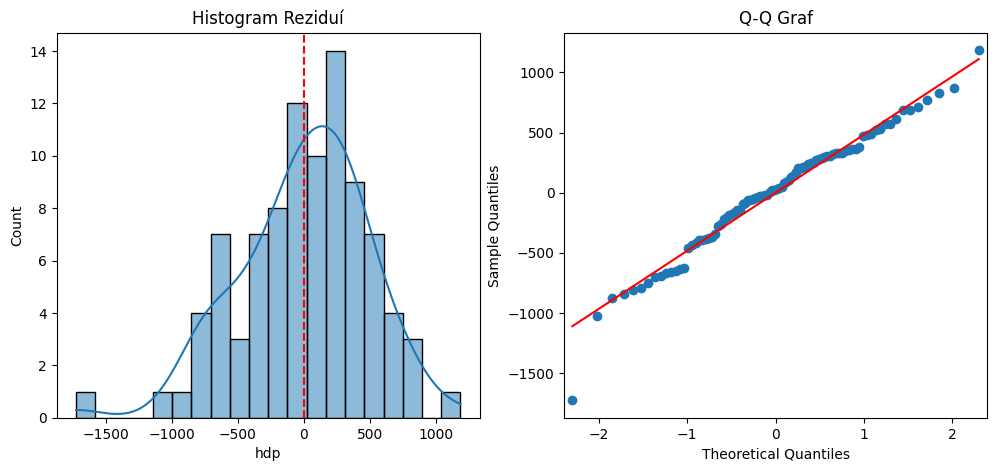

In [8]:
#Lasso
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)


y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)


lasso_r2_train = lasso_model.score(X_train, y_train)
lasso_r2_test = lasso_model.score(X_test, y_test)

print(f"Lasso Regresia R² (Train): {lasso_r2_train:.4f}")
print(f"Lasso Regresia R² (Test): {lasso_r2_test:.4f}")


lasso_residuals = y_train - y_train_pred




lasso_bp_test = het_breuschpagan(lasso_residuals, sm.add_constant(X_train))
print("\nBreusch-Pagan Test (Lasso Regression):")
print(f"Test Statistic: {lasso_bp_test[0]}, p-value: {lasso_bp_test[1]}")
if lasso_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(lasso_residuals)
print("\nShapiro-Wilk Test for Normality of Residuals:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(lasso_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(lasso_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()



Elastic Net R² (Train): 0.9901
Elastic Net R² (Test): 0.9813

Breusch-Pagan Test:
Test Statistic: 11.523196881234231, p-value: 0.07349116252651514
Reziduá nevykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test:
Test Statistic: 0.9782, p-value: 0.1256
Reziduá sú približne normálne.


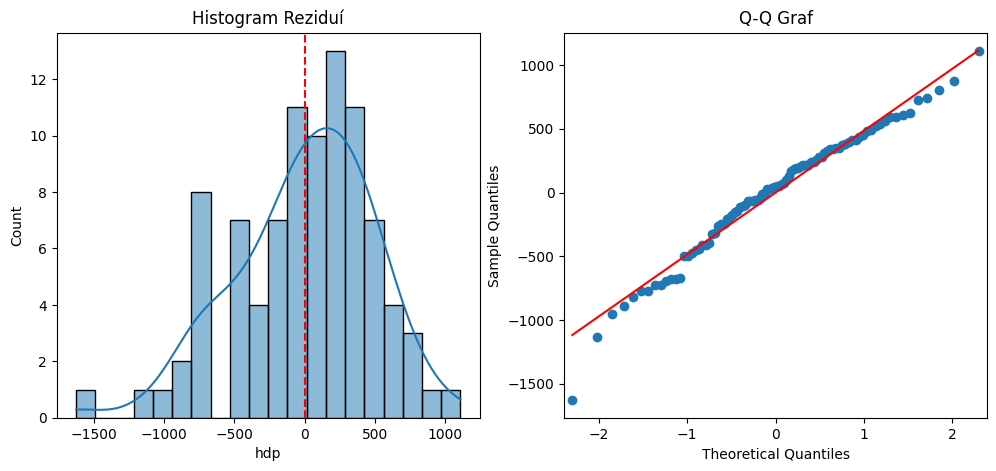

In [9]:
#Elastic net
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.9) 
elastic_model.fit(X_train, y_train)


y_train_pred = elastic_model.predict(X_train)
y_test_pred = elastic_model.predict(X_test)


elastic_r2_train = elastic_model.score(X_train, y_train)
elastic_r2_test = elastic_model.score(X_test, y_test)

print(f"Elastic Net R² (Train): {elastic_r2_train:.4f}")
print(f"Elastic Net R² (Test): {elastic_r2_test:.4f}")


elastic_residuals = y_train - y_train_pred





elastic_bp_test = het_breuschpagan(elastic_residuals, sm.add_constant(X_train))
print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {elastic_bp_test[0]}, p-value: {elastic_bp_test[1]}")
if elastic_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(elastic_residuals)
print("\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(elastic_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(elastic_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()

In [ ]:
#Residuá
models = {
    "Lineárna Regresia": mlr,
    "Ridge": ridge_model,
    "Lasso": lasso_model,
    "ElasticNet": elastic_model
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_train)
    residuals = y_train - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
    ax.axhline(y=0, color='red', linestyle='dashed') 
    ax.set_title(name)
    ax.set_xlabel("Predikované hodnoty")
    ax.set_ylabel("Reziduá")


plt.tight_layout()
plt.show()


In [ ]:
# Q-Q graf
residuals_lr = y_train - mlr.predict(X_train)
residuals_ridge = y_train - ridge_model.predict(X_train)
residuals_lasso = y_train - lasso_model.predict(X_train)
residuals_elastic = y_train - elastic_model.predict(X_train)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Q-Q Grafy", fontsize=16)

stats.probplot(residuals_lr, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title("Lineárna Regresia")


stats.probplot(residuals_ridge, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Ridge")


stats.probplot(residuals_lasso, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Lasso")


stats.probplot(residuals_elastic, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("ElasticNet")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [10]:
#Hodnotiace metriky
y_pred_train_lr = mlr.predict(X_train)  
y_pred_test_lr = mlr.predict(X_test)    

y_pred_train_ridge = ridge_model.predict(X_train)  
y_pred_test_ridge = ridge_model.predict(X_test)    

y_pred_train_lasso = lasso_model.predict(X_train)  
y_pred_test_lasso = lasso_model.predict(X_test)    

y_pred_train_elastic = elastic_model.predict(X_train)  
y_pred_test_elastic = elastic_model.predict(X_test)    


mse_test_lr = mean_squared_error(y_test, y_pred_test_lr)
mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_lr = np.sqrt(mse_test_lr)
mape_test_lr = mean_absolute_percentage_error(y_test, y_pred_test_lr)

mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)
rmse_test_ridge = np.sqrt(mse_test_ridge)
mape_test_ridge = mean_absolute_percentage_error(y_test, y_pred_test_ridge)

mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)
mape_test_lasso = mean_absolute_percentage_error(y_test, y_pred_test_lasso)

mse_test_elastic = mean_squared_error(y_test, y_pred_test_lr)
mae_test_elastic = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_elastic = np.sqrt(mse_test_elastic)
mape_test_elastic = mean_absolute_percentage_error(y_test, y_pred_test_elastic)



r2_lr = r2_test
r2_ridge = ridge_r2_test
r2_lasso = lasso_r2_test
r2_elastic = elastic_r2_test

metrics = {
    "Model": [
        "Lineárna Regresia",
        "Ridge",
        "Lasso",
        "ElasticNet"
    ],
    "MSE": [
        mse_test_lr,
        mse_test_ridge,
        mse_test_lasso,
        mse_test_elastic
    ],
    "MAE": [
        mae_test_lr,
        mae_test_ridge,
        mae_test_lasso,
        mae_test_elastic
    ],
    "RMSE": [
        rmse_test_lr,
        rmse_test_ridge,
        rmse_test_lasso,
        rmse_test_elastic
    ],
    "MAPE": [
        mape_test_lr,
        mape_test_ridge,
        mape_test_lasso,
        mape_test_elastic
    ],
    "R^2": [
        r2_lr,
        r2_ridge,
        r2_lasso,
        r2_elastic
    ]
}

# Convert to DataFrame
evaluation_df = pd.DataFrame(metrics)
evaluation_df

,Model,MSE,MAE,RMSE,MAPE,R^2
0,Lineárna Regresia,477212.584092,555.644715,690.805750,0.036015,0.981910
1,Ridge,478942.502617,555.935925,692.056719,0.036058,0.981844
2,Lasso,477193.175056,555.657507,690.791702,0.036015,0.981911
3,ElasticNet,477212.584092,555.644715,690.805750,0.036408,0.981254


In [28]:
#Koeficienty
ridge_coeffs = lasso_model.coef_
feature_names = X_train.columns
ridge_coeffs_df = pd.DataFrame(ridge_coeffs, index=feature_names, columns=['Koeficient'])
print("Intercept:", ridge_model.intercept_)
ridge_coeffs_df


Intercept: 18403.14014130435


,Koeficient
m2,2897.280358
nezamestnanost,-577.024953
urok,-1077.187933
olej,516.728967
bilancia,232.755892
tvorba_kapitalu,138.710503


In [ ]:
#Faktor inflácie rozptylu

vif_data = pd.DataFrame()
vif_data["Premenná"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]


vif_data.sort_values(by="VIF", ascending=False)


In [ ]:
#Krížová validácia
models = {
    "Lineárna Regresia": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5)
}


k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)


cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_results[name] = {
        "Priemerné R²": np.mean(scores),
        "Odchýlka R²": np.std(scores)
    }


for model, result in cv_results.items():
    print(f"{model}: Priemerné R² = {result['Priemerné R²']:.4f}, Odchýlka = {result['Odchýlka R²']:.4f}")


## Nezamestnanosť

In [11]:
#Rozdelenie a štandardizácia dát
#X = df_clean[df_clean.columns.difference(["nezamestnanost", "stvrtrok", "dovoz", "vyvoz", "pracovna_sila", "urok", "hicp", "vladne_vydavky", "tvorba_kapitalu" ])]
X = df_clean[df_clean.columns.difference(["nezamestnanost", "stvrtrok", "dovoz", "vyvoz", "pracovna_sila", "urok", "hicp", "vladne_vydavky", "tvorba_kapitalu", "m2", "ppi", "obyvatelia"])]
y = df_clean.nezamestnanost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [12]:

# Generate synthetic dataset


# Define models
models = {
    "Lineárna Regresia": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.9)
}

# DataFrame to store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    residuals = y_train - y_pred
    
    # Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = shapiro(residuals)
    
    # Breusch-Pagan test for heteroscedasticity
    X_with_const = sm.add_constant(X_train)  # Add constant term
    _, bp_pvalue, _, _ = het_breuschpagan(residuals, X_with_const)
    
    # Durbin-Watson test for autocorrelation
    dw_stat = durbin_watson(residuals)
    
    # Store results
    results.append({
        "Model": name,
        "SW p-hodnota": shapiro_p,
        "BP p-hodnota": bp_pvalue,
        "DW štatistika": dw_stat
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df

,Model,SW p-hodnota,BP p-hodnota,DW štatistika
0,Lineárna Regresia,0.787402,1.621269e-05,2.294493
1,Ridge,0.008804,1.466652e-04,2.301929
2,Lasso,0.005418,1.313834e-07,2.321942
3,Elastic Net,0.014738,5.785682e-08,2.303190


[[ 9.54  9.84]
 [14.3  11.49]
 [16.08 14.48]
 [13.94 14.29]
 [15.04 12.92]
 [12.36 11.14]
 [13.67 14.22]
 [14.03 13.88]
 [ 9.04 10.51]
 [13.34 13.03]
 [ 4.7   7.04]
 [16.64 16.95]
 [ 9.05  8.63]
 [ 5.56  5.33]
 [19.58 18.84]
 [14.28 11.72]
 [12.87 13.87]
 [18.23 18.56]
 [ 6.12  6.23]
 [13.24 11.36]
 [ 6.14  5.77]
 [ 6.56  5.53]
 [15.06 14.87]]
R² test: 0.8910853703533927
R² train: 0.9143646223874029
Shapiro-Wilk Test: Stat=0.9910, p=0.7874
Reziduá sú približne normálne.

Breusch-Pagan Test:
Test Statistic: 34.1405
p-value: 0.0000
Reziduá vykazujú signifkantnú heteroskedasticitu.


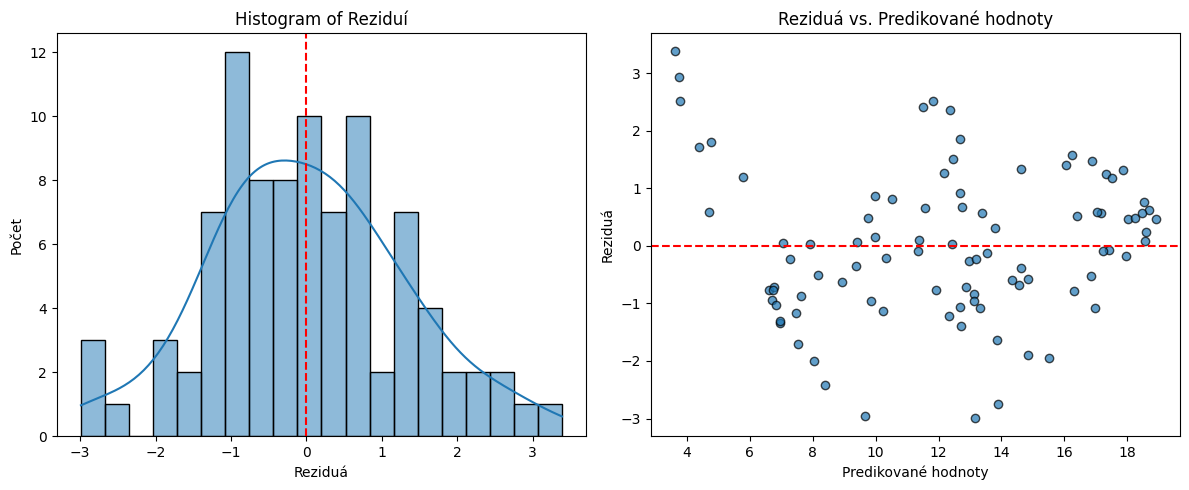

In [13]:
#Lineárna regresia
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_test = mlr.predict(X_test)
y_pred_train = mlr.predict(X_train)


np.set_printoptions(precision=2)
print(np.concatenate((np.array(y_pred_test).reshape(len(y_pred_test), 1), np.array(y_test).reshape(len(y_test), 1)), 1))

r2_test = mlr.score(X_test, y_test)
r2_train = mlr.score(X_train, y_train)
print(f"R² test: {r2_test}")
print(f"R² train: {r2_train}")

residuals = y_train - y_pred_train





stat, p = shapiro(residuals)
print(f"Shapiro-Wilk Test: Stat={stat:.4f}, p={p:.4f}")
if p > 0.05:
    print("Reziduá sú približne normálne.")
else:
    print("Reziduá sa signifikantne odchyľujú od normnality.")


X_test_with_const = sm.add_constant(X_train)
bp_test_stat, bp_test_pval, _, _ = het_breuschpagan(residuals, X_test_with_const)


print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat:.4f}")
print(f"p-value: {bp_test_pval:.4f}")


if bp_test_pval < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(residuals, bins=20, kde=True, ax=axs[0])
axs[0].axvline(0, color='red', linestyle='dashed') 
axs[0].set_title("Histogram of Reziduí")
axs[0].set_xlabel("Reziduá")
axs[0].set_ylabel("Počet")


axs[1].scatter(y_pred_train, residuals, alpha=0.7, edgecolor='k')
axs[1].axhline(y=0, color='red', linestyle='dashed')
axs[1].set_title("Reziduá vs. Predikované hodnoty")
axs[1].set_xlabel("Predikované hodnoty")
axs[1].set_ylabel("Reziduá")

plt.tight_layout()
plt.show()

In [21]:
#OLS

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 1: Add a constant to X_train for the intercept term
X_train_const = sm.add_constant(X_train)

# Step 2: Fit the OLS regression model
ols_model = sm.OLS(y_train, X_train_const).fit()

# Step 3: Print the OLS summary
print(ols_model.summary())



                            OLS Regression Results                            
Dep. Variable:         nezamestnanost   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     128.1
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           4.54e-42
Time:                        18:40:10   Log-Likelihood:                -153.57
No. Observations:                  92   AIC:                             323.1
Df Residuals:                      84   BIC:                             343.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.1470      0.140     86.679

Ridge Regresia R² (Train): 0.8990
Ridge Regresia R² (Test): 0.8787

Breusch-Pagan Test:
Test Statistic: 28.96765224946583, p-value: 0.00014666521957269735
Reziduá vykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test:
Test Statistic: 0.9620, p-value: 0.0088
Reziduá sa signifikantne odchyľujú od normnality.


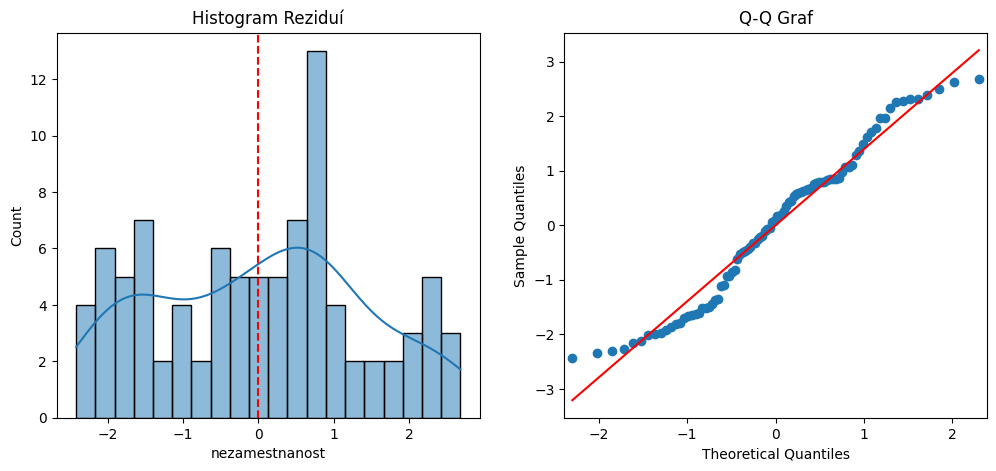

In [14]:
#Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)


y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)


ridge_r2_train = ridge_model.score(X_train, y_train)
ridge_r2_test = ridge_model.score(X_test, y_test)

print(f"Ridge Regresia R² (Train): {ridge_r2_train:.4f}")
print(f"Ridge Regresia R² (Test): {ridge_r2_test:.4f}")


ridge_residuals = y_train - y_train_pred





ridge_bp_test = het_breuschpagan(ridge_residuals, sm.add_constant(X_train))
print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {ridge_bp_test[0]}, p-value: {ridge_bp_test[1]}")
if ridge_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(ridge_residuals)
print("\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(ridge_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(ridge_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()


Lasso Regresia R² (Train): 0.8660
Lasso Regresia R² (Test): 0.8260

Breusch-Pagan Test:
Test Statistic: 45.08972975165736, p-value: 1.3138342204069496e-07
Reziduá vykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test:
Test Statistic: 0.9588, p-value: 0.0054
Reziduá sa signifikantne odchyľujú od normnality.


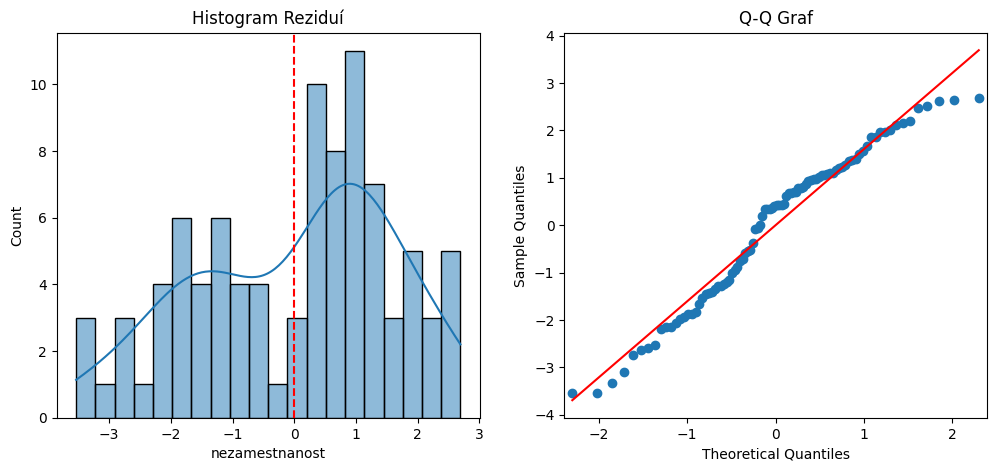

In [15]:
#Lasso
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)


y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)


lasso_r2_train = lasso_model.score(X_train, y_train)
lasso_r2_test = lasso_model.score(X_test, y_test)

print(f"Lasso Regresia R² (Train): {lasso_r2_train:.4f}")
print(f"Lasso Regresia R² (Test): {lasso_r2_test:.4f}")


lasso_residuals = y_train - y_train_pred





lasso_bp_test = het_breuschpagan(lasso_residuals, sm.add_constant(X_train))
print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {lasso_bp_test[0]}, p-value: {lasso_bp_test[1]}")
if lasso_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(lasso_residuals)
print("\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(lasso_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(lasso_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()

Elastic Net R² (Train): 0.8438
Elastic Net R² (Test): 0.8078

Breusch-Pagan Test:
Test Statistic: 46.92019889294921, p-value: 5.7856824932650624e-08
Reziduá vykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test:
Test Statistic: 0.9652, p-value: 0.0147
Reziduá sa signifikantne odchyľujú od normnality.


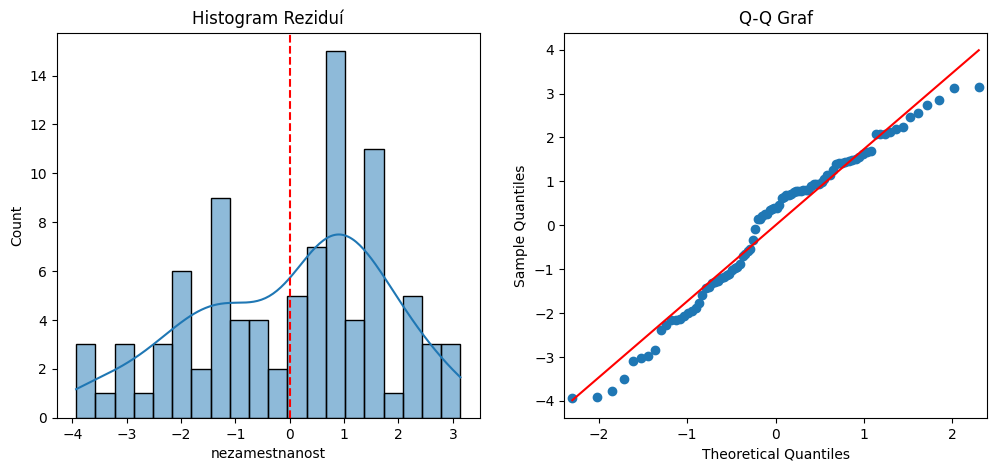

In [16]:
#Elastic net
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.9)
elastic_model.fit(X_train, y_train)


y_train_pred = elastic_model.predict(X_train)
y_test_pred = elastic_model.predict(X_test)


elastic_r2_train = elastic_model.score(X_train, y_train)
elastic_r2_test = elastic_model.score(X_test, y_test)

print(f"Elastic Net R² (Train): {elastic_r2_train:.4f}")
print(f"Elastic Net R² (Test): {elastic_r2_test:.4f}")


elastic_residuals = y_train - y_train_pred





elastic_bp_test = het_breuschpagan(elastic_residuals, sm.add_constant(X_train))
print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {elastic_bp_test[0]}, p-value: {elastic_bp_test[1]}")
if elastic_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(elastic_residuals)
print("\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(elastic_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(elastic_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()


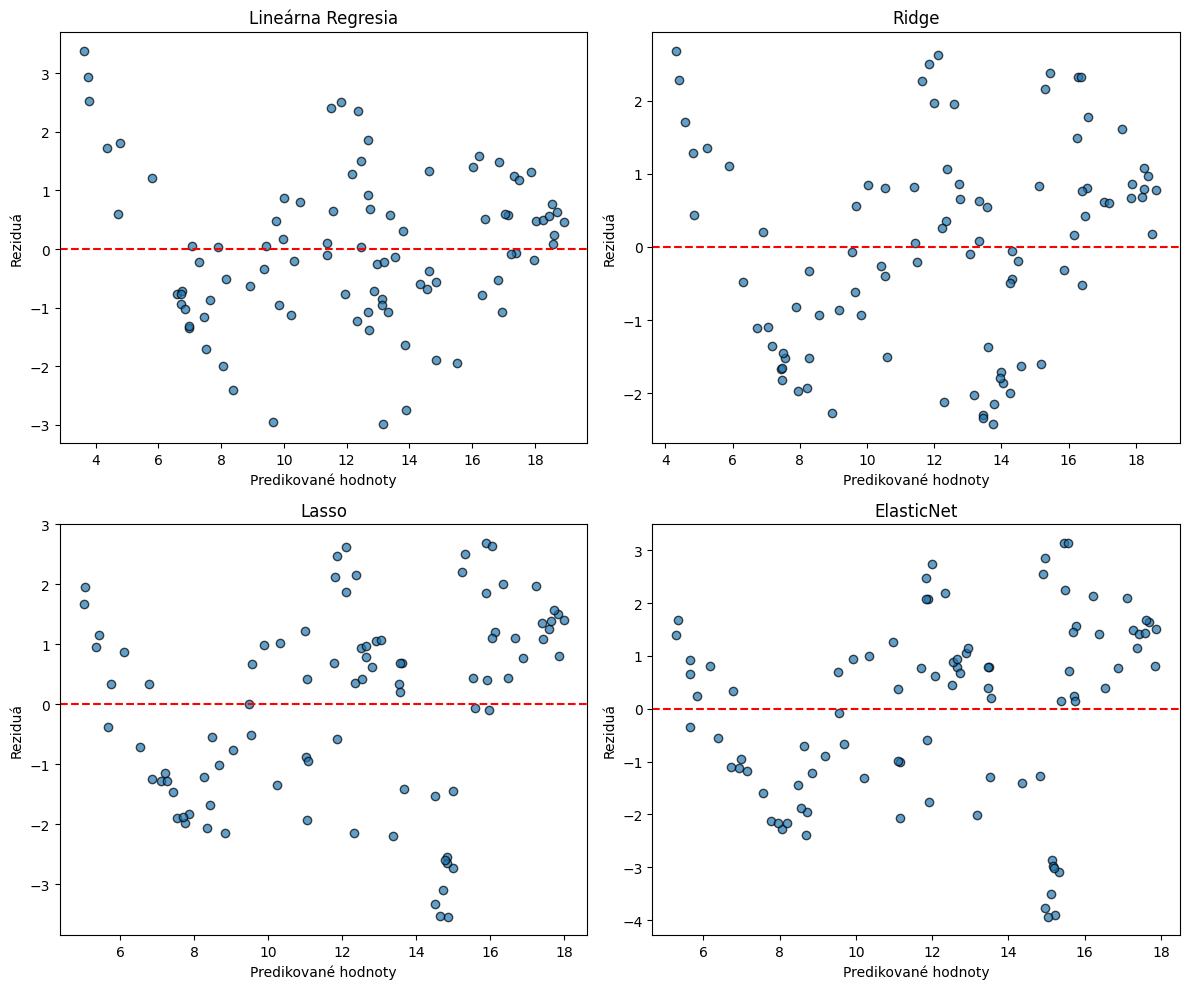

In [13]:
#Residuá
models = {
    "Lineárna Regresia": mlr,
    "Ridge": ridge_model,
    "Lasso": lasso_model,
    "ElasticNet": elastic_model
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_train)
    residuals = y_train - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
    ax.axhline(y=0, color='red', linestyle='dashed') 
    ax.set_title(name)
    ax.set_xlabel("Predikované hodnoty")
    ax.set_ylabel("Reziduá")


plt.tight_layout()
plt.show()


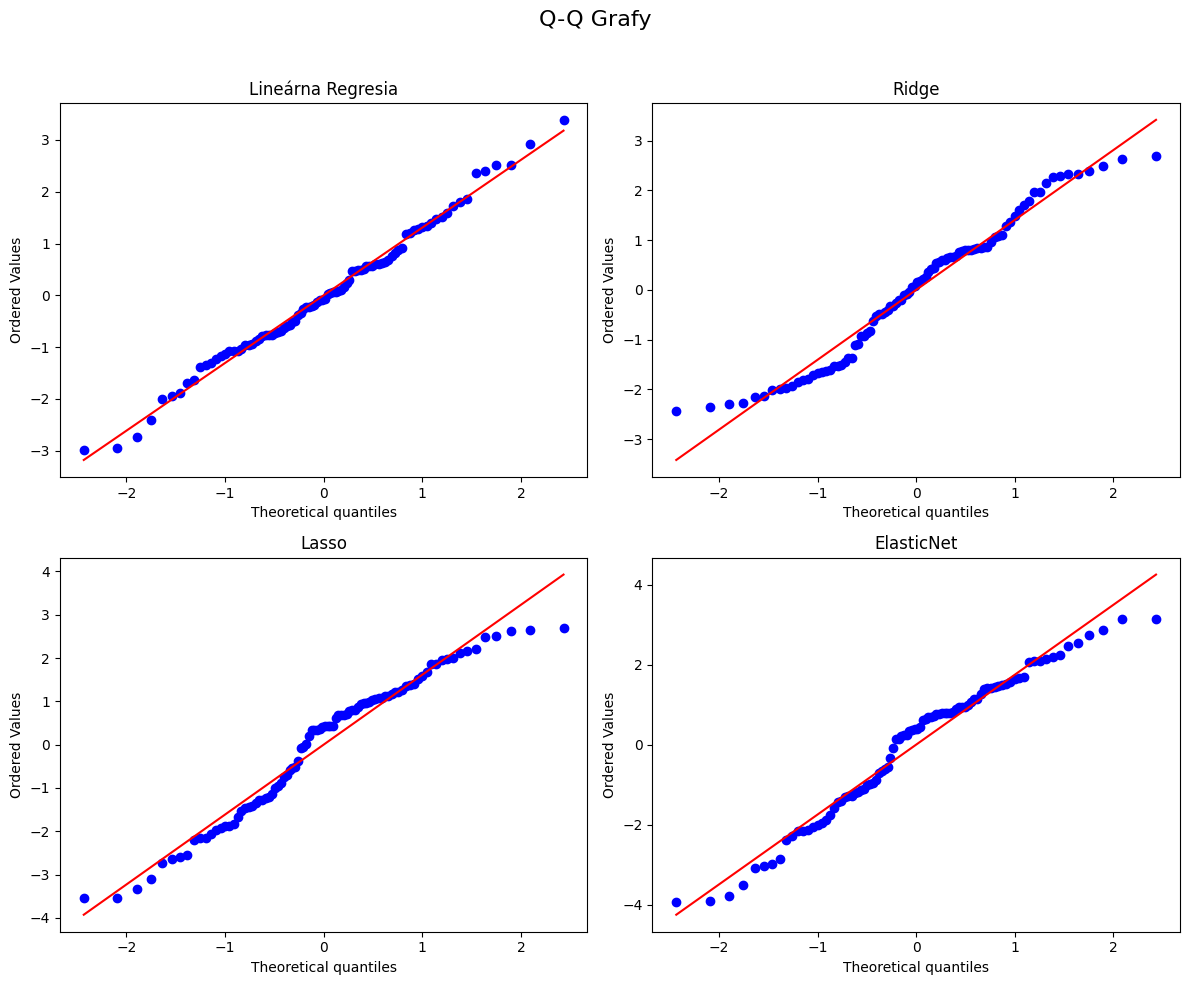

In [15]:
# Q-Q graf
residuals_lr = y_train - mlr.predict(X_train)
residuals_ridge = y_train - ridge_model.predict(X_train)
residuals_lasso = y_train - lasso_model.predict(X_train)
residuals_elastic = y_train - elastic_model.predict(X_train)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Q-Q Grafy", fontsize=16)

stats.probplot(residuals_lr, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title("Lineárna Regresia")


stats.probplot(residuals_ridge, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Ridge")


stats.probplot(residuals_lasso, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Lasso")


stats.probplot(residuals_elastic, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("ElasticNet")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [17]:
#Hodnotiace metriky
y_pred_train_lr = mlr.predict(X_train)  
y_pred_test_lr = mlr.predict(X_test)    

y_pred_train_ridge = ridge_model.predict(X_train)  
y_pred_test_ridge = ridge_model.predict(X_test)    

y_pred_train_lasso = lasso_model.predict(X_train)  
y_pred_test_lasso = lasso_model.predict(X_test)    

y_pred_train_elastic = elastic_model.predict(X_train)  
y_pred_test_elastic = elastic_model.predict(X_test)    


mse_test_lr = mean_squared_error(y_test, y_pred_test_lr)
mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_lr = np.sqrt(mse_test_lr)
mape_test_lr = mean_absolute_percentage_error(y_test, y_pred_test_lr)

mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)
rmse_test_ridge = np.sqrt(mse_test_ridge)
mape_test_ridge = mean_absolute_percentage_error(y_test, y_pred_test_ridge)

mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)
mape_test_lasso = mean_absolute_percentage_error(y_test, y_pred_test_lasso)

mse_test_elastic = mean_squared_error(y_test, y_pred_test_lr)
mae_test_elastic = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_elastic = np.sqrt(mse_test_elastic)
mape_test_elastic = mean_absolute_percentage_error(y_test, y_pred_test_elastic)



r2_lr = r2_test
r2_ridge = ridge_r2_test
r2_lasso = lasso_r2_test
r2_elastic = elastic_r2_test

metrics = {
    "Model": [
        "Lineárna Regresia",
        "Ridge",
        "Lasso",
        "ElasticNet"
    ],
    "MSE": [
        mse_test_lr,
        mse_test_ridge,
        mse_test_lasso,
        mse_test_elastic
    ],
    "MAE": [
        mae_test_lr,
        mae_test_ridge,
        mae_test_lasso,
        mae_test_elastic
    ],
    "RMSE": [
        rmse_test_lr,
        rmse_test_ridge,
        rmse_test_lasso,
        rmse_test_elastic
    ],
    "MAPE": [
        mape_test_lr,
        mape_test_ridge,
        mape_test_lasso,
        mape_test_elastic
    ],
    "R^2": [
        r2_lr,
        r2_ridge,
        r2_lasso,
        r2_elastic
    ]
}

# Convert to DataFrame
evaluation_df = pd.DataFrame(metrics)
evaluation_df

,Model,MSE,MAE,RMSE,MAPE,R^2
0,Lineárna Regresia,1.654437,0.973925,1.286249,0.092814,0.891085
1,Ridge,1.842245,1.082367,1.357293,0.103613,0.878722
2,Lasso,2.642345,1.329751,1.625529,0.123304,0.826050
3,ElasticNet,1.654437,0.973925,1.286249,0.128611,0.807769


In [19]:
#Faktor inflácie rozptylu

vif_data = pd.DataFrame()
vif_data["Premenná"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif_data.sort_values(by="VIF", ascending=False)

,Premenná,VIF
1,cpi,24.601251
3,hdp,20.389397
5,nehnutelnosti,15.869649
6,olej,3.866516
0,bilancia,3.594973
2,dlh,3.190482
4,kurz_usd_eur,2.020344


In [20]:
#Koeficienty
ridge_coeffs = mlr.coef_
feature_names = X_train.columns
ridge_coeffs_df = pd.DataFrame(ridge_coeffs, index=feature_names, columns=['Koeficient'])
print("Intercept:", ridge_model.intercept_)
ridge_coeffs_df

Intercept: 12.146961956521736


,Koeficient
bilancia,0.845915
cpi,7.640298
dlh,-1.700876
hdp,-8.973734
kurz_usd_eur,-0.758789
nehnutelnosti,-2.336687
olej,0.762686


In [17]:
#Krížová validácia
models = {
    "Lineárna Regresia": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5)
}


k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)


cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_results[name] = {
        "Priemerné R²": np.mean(scores),
        "Odchýlka R²": np.std(scores)
    }


for model, result in cv_results.items():
    print(f"{model}: Priemerné R² = {result['Priemerné R²']:.4f}, Odchýlka = {result['Odchýlka R²']:.4f}")


Lineárna Regresia: Priemerné R² = 0.8649, Odchýlka = 0.0672
Ridge: Priemerné R² = 0.8510, Odchýlka = 0.0744
Lasso: Priemerné R² = 0.8159, Odchýlka = 0.0855
Elastic Net: Priemerné R² = 0.7443, Odchýlka = 0.1238


## Inflácia

In [9]:
#Rozdelenie a štandardizácia dát
X = df_clean[df_clean.columns.difference(["stvrtrok", "cpi" , "dovoz", "vyvoz", "nehnutelnosti", "olej", "tvorba_kapitalu", "pracovna_sila", "kurz_usd_eur", "obyvatelia", "vladne_vydavky", "m2", "bilancia", "hicp"])]
y = df_clean.cpi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [24]:

# Generate synthetic dataset


# Define models
models = {
    "Lineárna Regresia": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.9)
}

# DataFrame to store results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    residuals = y_train - y_pred
    
    # Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = shapiro(residuals)
    
    # Breusch-Pagan test for heteroscedasticity
    X_with_const = sm.add_constant(X_train)  # Add constant term
    _, bp_pvalue, _, _ = het_breuschpagan(residuals, X_with_const)
    
    # Durbin-Watson test for autocorrelation
    dw_stat = durbin_watson(residuals)
    
    # Store results
    results.append({
        "Model": name,
        "SW p-hodnota": shapiro_p,
        "BP p-hodnota": bp_pvalue,
        "DW štatistika": dw_stat
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df

,Model,SW p-hodnota,BP p-hodnota,DW štatistika
0,Lineárna Regresia,0.003896,0.026367,2.277751
1,Ridge,0.009438,0.016677,2.291624
2,Lasso,0.005729,0.024990,2.285142
3,Elastic Net,0.010238,0.007229,2.294691


[[162.83 162.94]
 [ 83.1   73.01]
 [136.22 135.25]
 [165.33 164.32]
 [ 88.69  79.24]
 [141.83 139.61]
 [165.51 164.23]
 [168.83 162.16]
 [150.47 141.73]
 [ 94.08  80.58]
 [178.45 178.2 ]
 [130.38 129.65]
 [164.07 163.89]
 [215.43 232.8 ]
 [107.14  98.55]
 [ 77.63  68.8 ]
 [165.25 163.93]
 [115.62 108.8 ]
 [202.88 203.27]
 [147.93 148.69]
 [172.31 174.16]
 [216.58 231.28]
 [ 94.95  83.77]]
R²: 0.9727585080461784


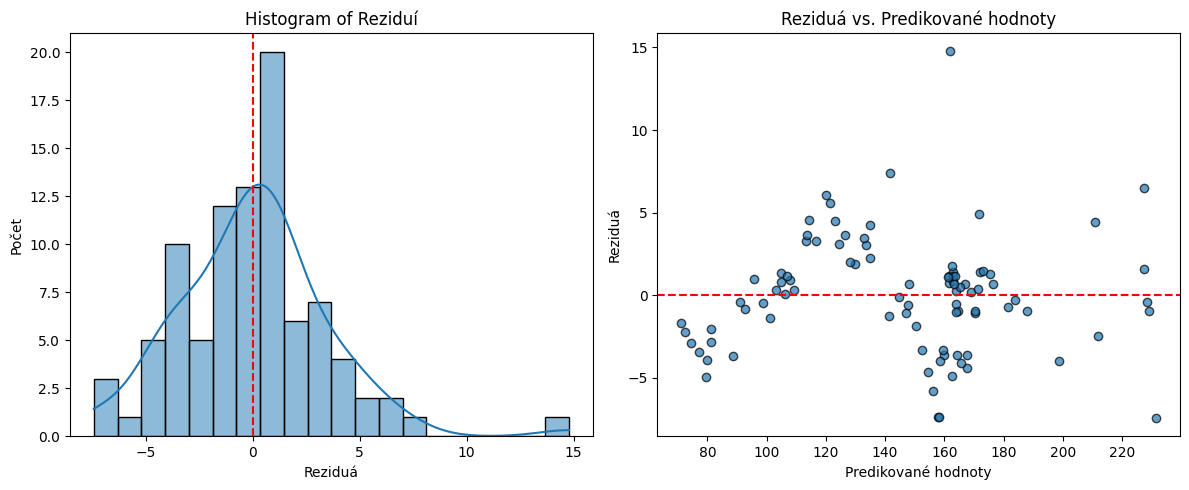

Shapiro-Wilk Test: Stat=0.9567, p=0.0039
Reziduá sa signifikantne odchyľujú od normnality.

Breusch-Pagan Test:
Test Statistic: 12.6992
p-value: 0.0264
Reziduá vykazujú signifkantnú heteroskedasticitu.


In [19]:
#Lineárna regresia
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_test = mlr.predict(X_test)
y_pred_train = mlr.predict(X_train)

np.set_printoptions(precision=2)
print(np.concatenate((np.array(y_pred_test).reshape(len(y_pred_test), 1), np.array(y_test).reshape(len(y_test), 1)), 1))

r2_test = mlr.score(X_test, y_test)
print(f"R²: {r2_test}")


residuals = y_train - y_pred_train


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(residuals, bins=20, kde=True, ax=axs[0])
axs[0].axvline(0, color='red', linestyle='dashed') 
axs[0].set_title("Histogram of Reziduí")
axs[0].set_xlabel("Reziduá")
axs[0].set_ylabel("Počet")


axs[1].scatter(y_pred_train, residuals, alpha=0.7, edgecolor='k')
axs[1].axhline(y=0, color='red', linestyle='dashed')
axs[1].set_title("Reziduá vs. Predikované hodnoty")
axs[1].set_xlabel("Predikované hodnoty")
axs[1].set_ylabel("Reziduá")

plt.tight_layout()
plt.show()


stat, p = shapiro(residuals)
print(f"Shapiro-Wilk Test: Stat={stat:.4f}, p={p:.4f}")
if p > 0.05:
    print("Reziduá sú približne normálne.")
else:
    print("Reziduá sa signifikantne odchyľujú od normnality.")


X_test_with_const = sm.add_constant(X_train)
bp_test_stat, bp_test_pval, _, _ = het_breuschpagan(residuals, X_test_with_const)


print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat:.4f}")
print(f"p-value: {bp_test_pval:.4f}")


if bp_test_pval < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


In [35]:
#OLS

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_train_const = sm.add_constant(X_train)


ols_model = sm.OLS(y_train, X_train_const).fit()


print(ols_model.summary())



                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2154.
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           9.86e-89
Time:                        14:24:08   Log-Likelihood:                -244.40
No. Observations:                  92   AIC:                             500.8
Df Residuals:                      86   BIC:                             515.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            145.4572      0.372    391.

Ridge Regresia R² (Train): 0.9913
Ridge Regresia R² (Test): 0.9704

Breusch-Pagan Test:
Test Statistic: 13.837261787867234, p-value: 0.016676874223920418
Reziduá vykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test:
Test Statistic: 0.9624, p-value: 0.0094
Reziduá sa signifikantne odchyľujú od normnality.


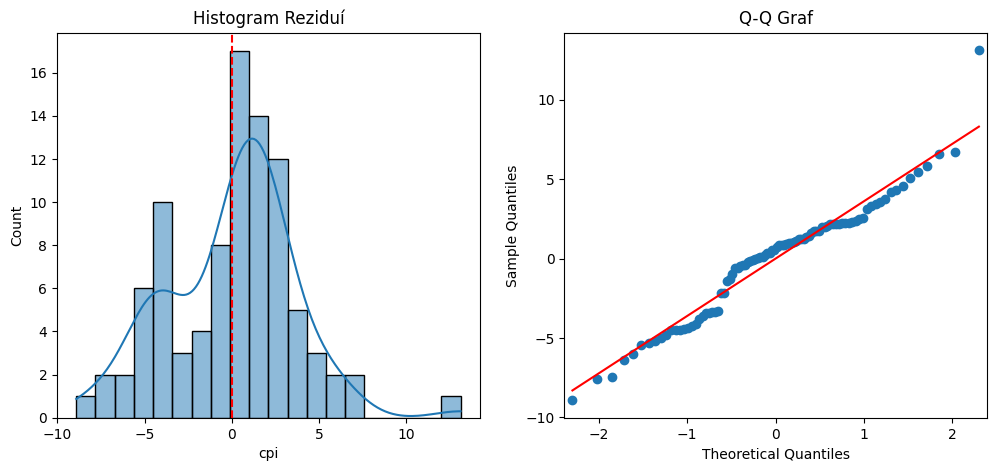

In [25]:
#Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)


y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)


ridge_r2_train = ridge_model.score(X_train, y_train)
ridge_r2_test = ridge_model.score(X_test, y_test)

print(f"Ridge Regresia R² (Train): {ridge_r2_train:.4f}")
print(f"Ridge Regresia R² (Test): {ridge_r2_test:.4f}")


ridge_residuals = y_train - y_train_pred





ridge_bp_test = het_breuschpagan(ridge_residuals, sm.add_constant(X_train))
print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {ridge_bp_test[0]}, p-value: {ridge_bp_test[1]}")
if ridge_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(ridge_residuals)
print("\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(ridge_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(ridge_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()


Lasso Regresia R² (Train): 0.9920
Lasso Regresia R² (Test): 0.9717

Breusch-Pagan Test:
Test Statistic: 12.83347878777299, p-value: 0.024990240332331395
Reziduá vykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test:
Test Statistic: 0.9592, p-value: 0.0057
Reziduá sa signifikantne odchyľujú od normnality.


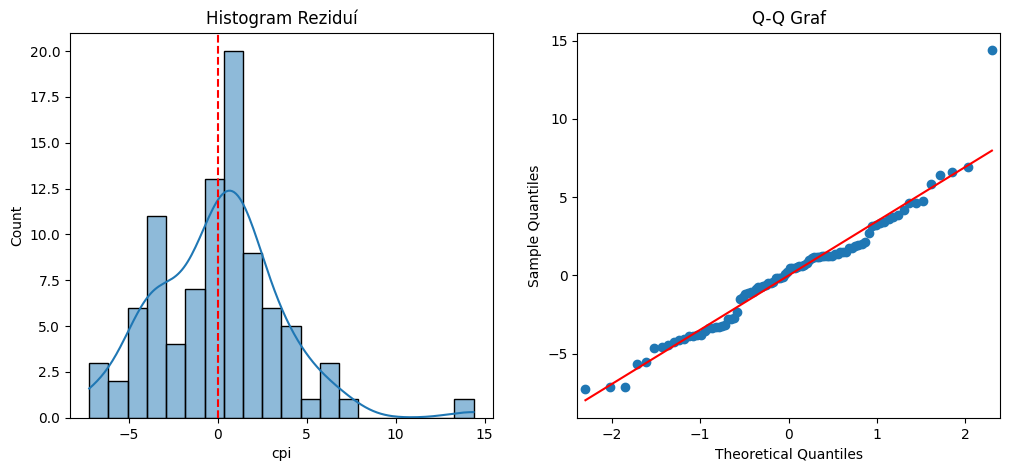

In [26]:
#Lasso
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)


y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)


lasso_r2_train = lasso_model.score(X_train, y_train)
lasso_r2_test = lasso_model.score(X_test, y_test)

print(f"Lasso Regresia R² (Train): {lasso_r2_train:.4f}")
print(f"Lasso Regresia R² (Test): {lasso_r2_test:.4f}")


lasso_residuals = y_train - y_train_pred





lasso_bp_test = het_breuschpagan(lasso_residuals, sm.add_constant(X_train))
print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {lasso_bp_test[0]}, p-value: {lasso_bp_test[1]}")
if lasso_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(lasso_residuals)
print("\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(lasso_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(lasso_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()


Elastic Net R² (Train): 0.9911
Elastic Net R² (Test): 0.9695

Breusch-Pagan Test:
Test Statistic: 15.868667240677961, p-value: 0.007229211349823436
Reziduá vykazujú signifkantnú heteroskedasticitu.

Shapiro-Wilk Test:
Test Statistic: 0.9629, p-value: 0.0102
Reziduá sa signifikantne odchyľujú od normnality.


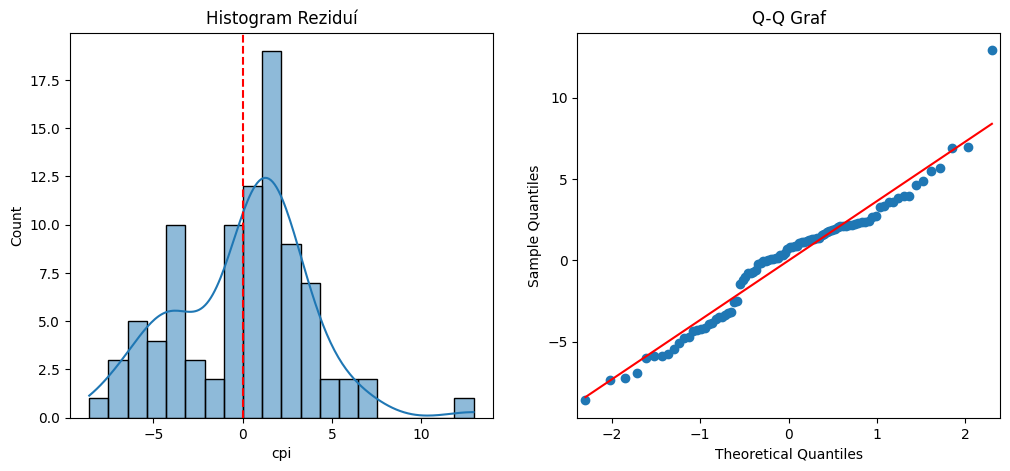

In [27]:
#Elastic net
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.9)
elastic_model.fit(X_train, y_train)


y_train_pred = elastic_model.predict(X_train)
y_test_pred = elastic_model.predict(X_test)


elastic_r2_train = elastic_model.score(X_train, y_train)
elastic_r2_test = elastic_model.score(X_test, y_test)

print(f"Elastic Net R² (Train): {elastic_r2_train:.4f}")
print(f"Elastic Net R² (Test): {elastic_r2_test:.4f}")


elastic_residuals = y_train - y_train_pred





elastic_bp_test = het_breuschpagan(elastic_residuals, sm.add_constant(X_train))
print("\nBreusch-Pagan Test:")
print(f"Test Statistic: {elastic_bp_test[0]}, p-value: {elastic_bp_test[1]}")
if elastic_bp_test[1] < 0.05:
    print("Reziduá vykazujú signifkantnú heteroskedasticitu.")
else:
    print("Reziduá nevykazujú signifkantnú heteroskedasticitu.")


shapiro_test_stat, shapiro_p_value = shapiro(elastic_residuals)
print("\nShapiro-Wilk Test:")
print(f"Test Statistic: {shapiro_test_stat:.4f}, p-value: {shapiro_p_value:.4f}")
if shapiro_p_value < 0.05:
    print("Reziduá sa signifikantne odchyľujú od normnality.")
else:
    print("Reziduá sú približne normálne.")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))


sns.histplot(elastic_residuals, kde=True, bins=20, ax=axs[0])
axs[0].set_title("Histogram Reziduí")
axs[0].axvline(0, color='red', linestyle='--')


sm.qqplot(elastic_residuals, line='s', ax=axs[1])
axs[1].set_title("Q-Q Graf")

plt.show()


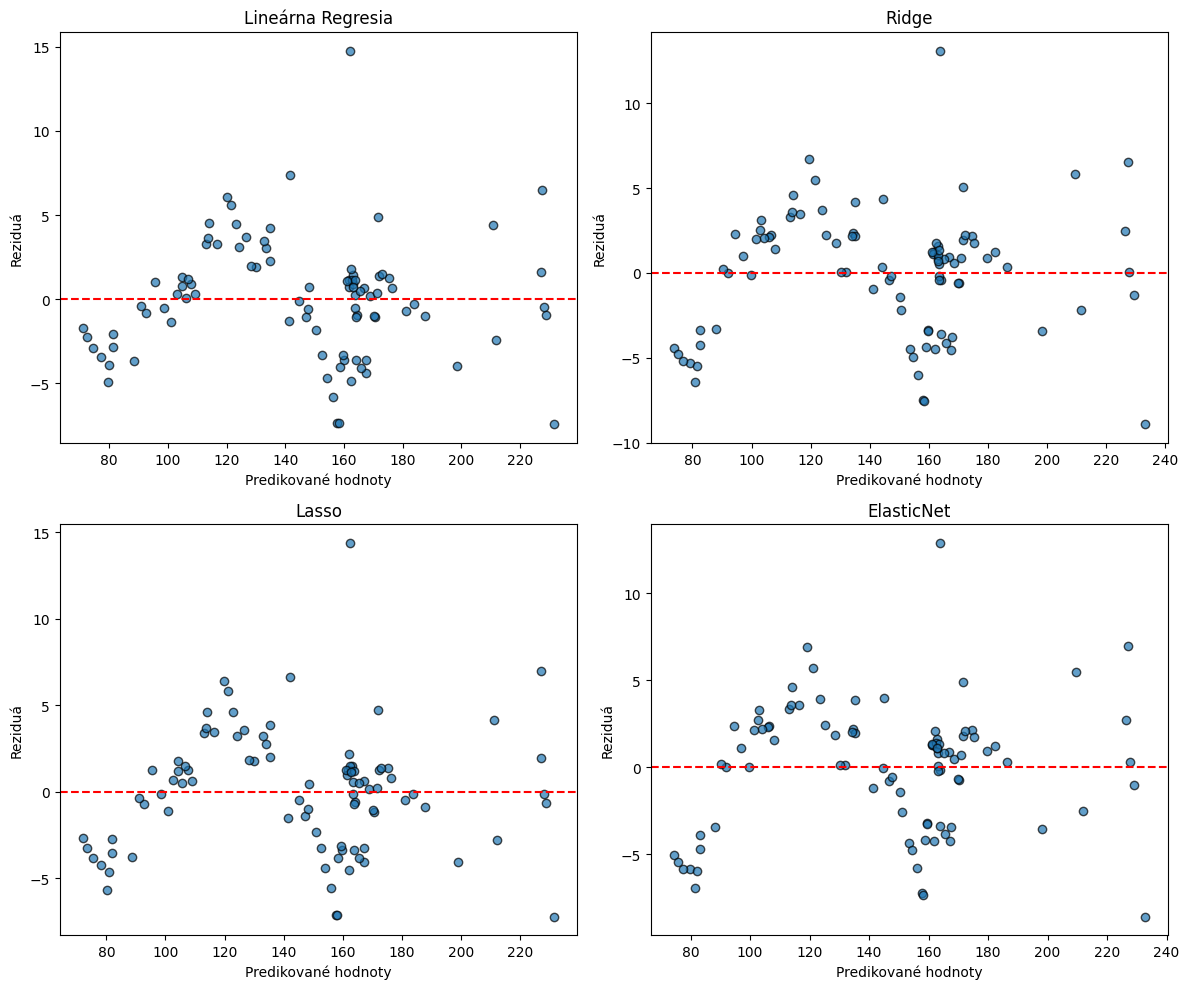

In [28]:
#Residuá
models = {
    "Lineárna Regresia": mlr,
    "Ridge": ridge_model,
    "Lasso": lasso_model,
    "ElasticNet": elastic_model
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_train)
    residuals = y_train - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
    ax.axhline(y=0, color='red', linestyle='dashed') 
    ax.set_title(name)
    ax.set_xlabel("Predikované hodnoty")
    ax.set_ylabel("Reziduá")


plt.tight_layout()
plt.show()


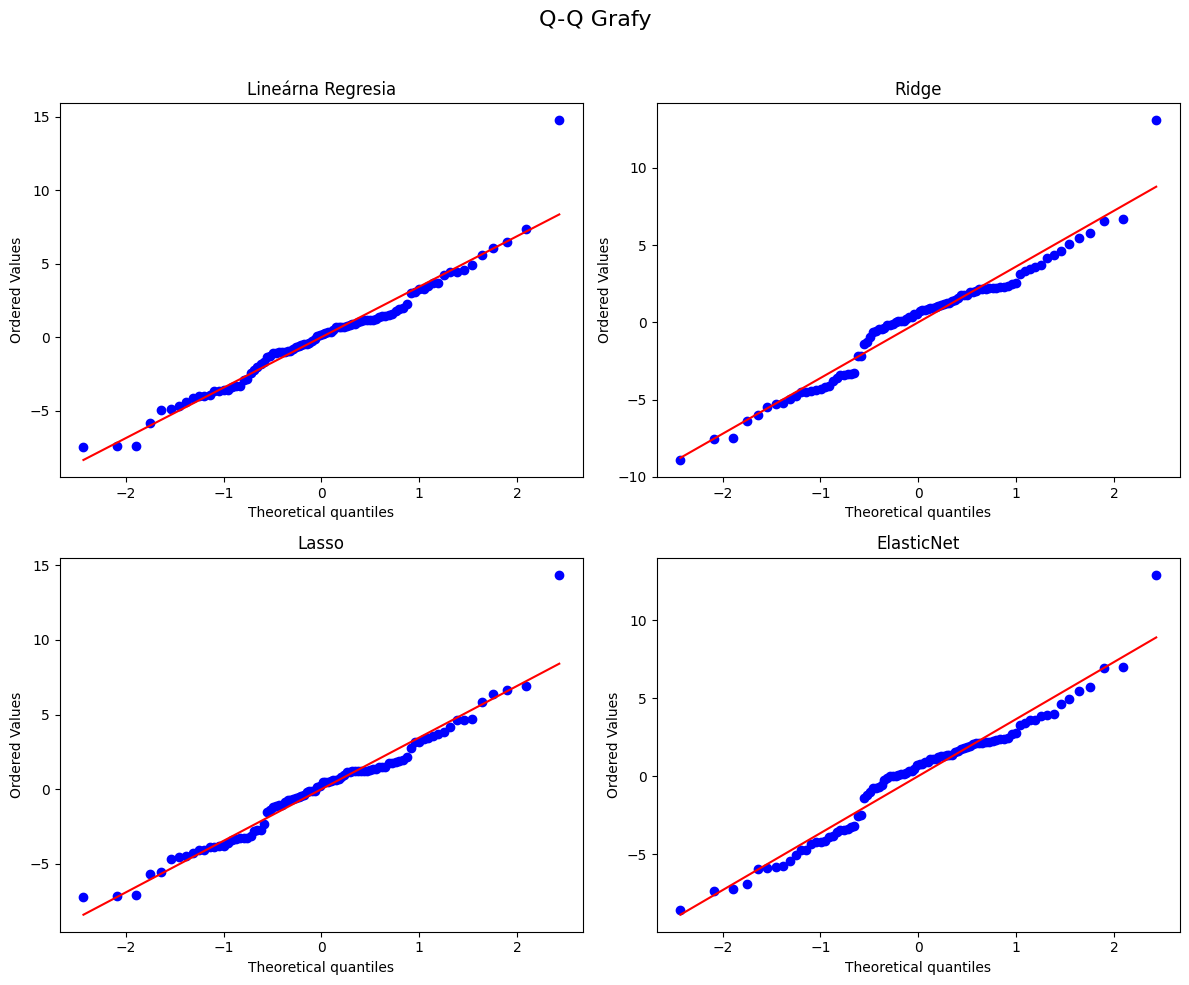

In [30]:
# Q-Q graf
residuals_lr = y_train - mlr.predict(X_train)
residuals_ridge = y_train - ridge_model.predict(X_train)
residuals_lasso = y_train - lasso_model.predict(X_train)
residuals_elastic = y_train - elastic_model.predict(X_train)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Q-Q Grafy", fontsize=16)

stats.probplot(residuals_lr, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title("Lineárna Regresia")


stats.probplot(residuals_ridge, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Ridge")


stats.probplot(residuals_lasso, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Lasso")


stats.probplot(residuals_elastic, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("ElasticNet")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [33]:
#Hodnotiace metriky
y_pred_train_lr = mlr.predict(X_train)  
y_pred_test_lr = mlr.predict(X_test)    

y_pred_train_ridge = ridge_model.predict(X_train)  
y_pred_test_ridge = ridge_model.predict(X_test)    

y_pred_train_lasso = lasso_model.predict(X_train)  
y_pred_test_lasso = lasso_model.predict(X_test)    

y_pred_train_elastic = elastic_model.predict(X_train)  
y_pred_test_elastic = elastic_model.predict(X_test)    


mse_test_lr = mean_squared_error(y_test, y_pred_test_lr)
mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_lr = np.sqrt(mse_test_lr)
mape_test_lr = mean_absolute_percentage_error(y_test, y_pred_test_lr)

mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
mae_test_ridge = mean_absolute_error(y_test, y_pred_test_ridge)
rmse_test_ridge = np.sqrt(mse_test_ridge)
mape_test_ridge = mean_absolute_percentage_error(y_test, y_pred_test_ridge)

mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
mae_test_lasso = mean_absolute_error(y_test, y_pred_test_lasso)
rmse_test_lasso = np.sqrt(mse_test_lasso)
mape_test_lasso = mean_absolute_percentage_error(y_test, y_pred_test_lasso)

mse_test_elastic = mean_squared_error(y_test, y_pred_test_lr)
mae_test_elastic = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_elastic = np.sqrt(mse_test_elastic)
mape_test_elastic = mean_absolute_percentage_error(y_test, y_pred_test_elastic)



r2_lr = r2_test
r2_ridge = ridge_r2_test
r2_lasso = lasso_r2_test
r2_elastic = elastic_r2_test

metrics = {
    "Model": [
        "Lineárna Regresia",
        "Ridge",
        "Lasso",
        "ElasticNet"
    ],
    "MSE": [
        mse_test_lr,
        mse_test_ridge,
        mse_test_lasso,
        mse_test_elastic
    ],
    "MAE": [
        mae_test_lr,
        mae_test_ridge,
        mae_test_lasso,
        mae_test_elastic
    ],
    "RMSE": [
        rmse_test_lr,
        rmse_test_ridge,
        rmse_test_lasso,
        rmse_test_elastic
    ],
    "MAPE": [
        mape_test_lr,
        mape_test_ridge,
        mape_test_lasso,
        mape_test_elastic
    ],
    "R^2": [
        r2_lr,
        r2_ridge,
        r2_lasso,
        r2_elastic
    ]
}

# Convert to DataFrame
evaluation_df = pd.DataFrame(metrics)
evaluation_df

,Model,MSE,MAE,RMSE,MAPE,R^2
0,Lineárna Regresia,58.680980,5.519654,7.660351,0.049943,0.972759
1,Ridge,63.708309,5.759569,7.981749,0.052375,0.970425
2,Lasso,60.917403,5.497364,7.804960,0.050457,0.971720
3,ElasticNet,58.680980,5.519654,7.660351,0.052867,0.969496


In [32]:
#Faktor inflácie rozptylu
vif_data = pd.DataFrame()
vif_data["Premenná"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

vif_data.sort_values(by="VIF", ascending=False)

,Premenná,VIF
1,hdp,26.077678
4,urok,11.499428
2,nezamestnanost,4.617200
3,ppi,3.086924
0,dlh,3.081395


In [34]:
#Koeficienty
ridge_coeffs = mlr.coef_
feature_names = X_train.columns
ridge_coeffs_df = pd.DataFrame(ridge_coeffs, index=feature_names, columns=['Koeficient'])
print("Intercept:", ridge_model.intercept_)
ridge_coeffs_df

Intercept: 145.45717608695654


,Koeficient
dlh,5.001964
hdp,29.207929
nezamestnanost,6.859298
ppi,11.881125
urok,-2.881654


In [23]:
X_train.columns

Index(['dlh', 'hdp', 'nezamestnanost', 'ppi', 'urok'], dtype='object')

In [ ]:
#Krížová validácia
models = {
    "Lineárna Regresia": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.5)
}


k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)


cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_results[name] = {
        "Priemerné R²": np.mean(scores),
        "Odchýlka R²": np.std(scores)
    }


for model, result in cv_results.items():
    print(f"{model}: Priemerné R² = {result['Priemerné R²']:.4f}, Odchýlka = {result['Odchýlka R²']:.4f}")
